In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import segyio
import itertools
import scipy.ndimage
import pandas as pd
from mayavi import mlab

## Practical 3 - Visualising stacked (fully processed) 3D seismic reflection data


In this exercise you will learn how to load fully processed 3D seismic reflection data in SEGY format and view it with Python. Traditionally, geologists and geophysicists have used proprietary software to do this. This software is very expensive, a bit of a black box and takes time to learn how to operate. In the next 3 hours you will be able to view and analyse seismic data without the need for such software by working through Practical 3 and 4.  

At the end of the exercise there is an extension activity to load some SEGY data that are partially incomplete. You **WON'T NEED THIS FOR THESE EXERCISES**, but if you download your own SEGY data you may have to apply these steps to get it loaded correctly (so this practical may be useful if you work with SEGY data for your independent project). 

**If you have time see [Bonus](./Ex3_Bonus.ipynb) excercise.**

**Learning objectives**:
1) understand how fully processed seismic data is stored and how to access this within python
2) Understand the important headers for plotting data
3) Learn how to plot data in different ways (wiggle traces, variable density, colour scales, etc.)

## 3.1 - Using SEGY data volumes

In this section you are provided with a perfect data cube, this means that the dataset has no missing points and it is structured in such a way that the segyio library can deal with reading in this file without the user requiring to adjust the dataset. In this activity we are using ["segyio"](https://segyio.readthedocs.io/en/latest/) to read the data into a numpy array, however, there are other tools available to do this. 

We are going to start with dataset TNW_small2. This is a sub-cube from a larger 3D data volume. As we discussed in at the end of lecture 6 it is from offshore the Netherlands and is located in a region of planned wind farm activities. The dataset has been collected with a sparker source and has been post-stack depth migrated. It images from 47.05 m below the seabed to 92.05 m. 


In [4]:
base_segy = segyio.open('../data/TNW_small2', ignore_geometry= False) 
print (segyio.tools.wrap(base_segy.text[0]))

C 1 SEGY OUTPUT FROM Petrel 2017.1 Thursday, November 18 2021 12:55:27
C 2 Name: TNW_3DUHRSsubset_ImperialCollege20211104 Crop 1 Type: 3D seismic    C
3                                                                             C
4 First inline: 2000   Last inline: 2571                                      C
5 First xline:  1316   Last xline:  1839                                      C
6 CRS: Undefined                                                              C
7 X min: 676054.47 max: 676326.12 delta: 271.65                               C
8 Y min: 5987532.19 max: 5987827.05 delta: 294.86                             C
9 Time min: -92.05 max: -47.05 delta: 45.00
C10 Lat min: - max: - delta: -
C11 Long min: - max: - delta: -
C12 Trace min: -92.00 max: -47.10 delta: 44.90
C13 Seismic (template) min: ~-39.39 max: ~66.61 delta: ~106.01
C14 Amplitude (data) min: ~-39.39 max: ~66.61 delta: ~106.01
C15 Trace sample format: IEEE floating point
C16 Coordinate scale factor: 100.00000
C17
C18

**Exercise 1: Have a careful read  through the EBCDIC header and try to recognise some of the terms we have learned about in the lecture. How many inlines are there? Can you identify in the EBCDIC where the depth range is given (does anything surprise you about this)?**

In [5]:
depth = base_segy.samples 
inlines = base_segy.ilines 
xlines = base_segy.xlines
data = segyio.tools.cube(base_segy)

In [6]:
print (inlines.size) # inline numbers
print (xlines.size) # xline numbers
print (depth.size) # time/depth samples
print (data.shape) # data in 3d array

572
524
450
(572, 524, 450)


<details>
    <summary>💡 Answer</summary>
There are 572 inlines and 524 xlines. The depth range is labelled as
Time min: -92.05 max: -47.05  
for some reason. We think this might be a mistake when the EBCDIC was written as this should be depth rather than time. There are 450 vertical samples.

Note: The data cube indexing first position is 0,0,0 which in this case equates to inline 2000.  

If the SEGY data is rectangular, perfectly structured and is not missing any data we can directly extract the below attributes from the dataset without any further work. You can see an example of a non-perfectly structured dataset in the extension exercise if you wish (ST020.segy) and how we recover this information in this case. In an assessment you will be given a perfectly structured cube- however, if you download your own data from a repository online you may encounter some imperfect data!

## 3.2 - visualising 3D seismic data volumes 
In this section we will focus on visualising a perfect 3D seismic reflection data volume. You will learn how to view inlines, xlines and time-slices and how to change the colours to help you visualise geological features.


### 3.2.1 3D visualisation
The python library [`mayavi`]((https://towardsdatascience.com/visualizing-3d-seismic-volumes-made-easy-with-python-and-mayavi-e0ca3fd61e43)) is a great and efficient 3D visualisation tool that we will be using to visualise our seismic data volumes.

In [7]:
def explore3d(data_cube, preset = True, I=-1, X = -1 , Z=-1):
    """
    
    """
    source = mlab.pipeline.scalar_field(data_cube)
    source.spacing = [1, 1, -1]
    vm = np.percentile(data_cube, 95) #may need to play a little with the 95
    
    if preset == True:
        nx, ny, nz = data_cube.shape
        I = nx//2
        X = ny//2
        Z = nz//2

    mlab.pipeline.image_plane_widget(source, plane_orientation='x_axes', 
                                     slice_index=I, colormap='coolwarm', vmin=-vm, vmax=vm)
    mlab.pipeline.image_plane_widget(source, plane_orientation='y_axes', 
                                     slice_index=X, colormap='coolwarm', vmin=-vm, vmax=vm)
    mlab.pipeline.image_plane_widget(source, plane_orientation='z_axes', 
                                     slice_index=Z, colormap='coolwarm', vmin=-vm, vmax=vm)
    mlab.show()

In [8]:
# geological features of interest at these locations
I = np.where(inlines == 2285)[0][0]
X = np.where (xlines == 1578)[0][0]
Z = np.where (depth == 60)[0][0]
explore3d(data, preset = False, I = I, X = X, Z = Z)

### 3.2.2 dynamic range

**Exercise 2: Try to visualize your data for inline = 2200** 

Hint: you need to define a boundary in which the x would be your crossline (`xlines[0]`, `xlines[-1]`) and the y would be the depth (`depth[0]`, `depth[-1]`)**

Reminder: `np.where` would help you to find the inline index

Text(0, 0.5, 'Depth (m)')

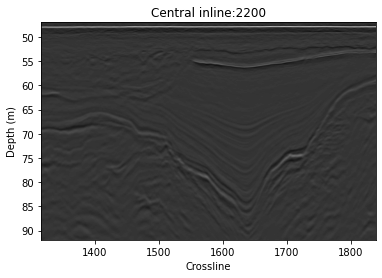

In [18]:
boundary = [xlines[0], xlines[-1],depth[-1], depth[0]] # used to set axis values
inline =  data[np.where(inlines == 2200)[0][0],:,:] #pull data for our inline of interest
plt.imshow(inline.T,extent = boundary, cmap='gray', aspect='auto')

plt.title('Central inline:' + str(inlines[np.where(inlines == 2200)[0][0]]))
plt.xlabel('Crossline')
plt.ylabel('Depth (m)')

**dynamic range**  -> the range of total difference between the lightest light and darkest dark of an image (** LECTURE 4 slide 18**)

In our plots above we are limited by an 8-bit image representation, we can visualise 256 shades. For this to work our wide spread of amplitudes needs to be compressed into these 256 shades. However having large outliers will jeperdise having a good dynamic range. To solve this we can clip outliers so we can use our available dynamic range better. 

Text(0, 0.5, 'Depth (m)')

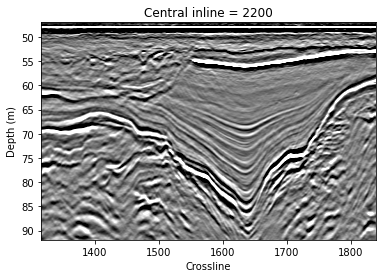

In [19]:
vm = np.percentile(data, 95) # remove 5% of high values (should remove all outliers as well)
boundary = [xlines[0], xlines[-1],depth[-1], depth[0]]
inline =  data[np.where(inlines == 2200)[0][0],:,:] ## you can change the inline to s
plt.imshow(inline.T,extent = boundary, cmap='gray', aspect='auto',vmin=-vm, vmax=vm)

plt.title('Central inline = ' + str(inlines[np.where(inlines == 2200)[0][0]]))
plt.xlabel('Crossline')
plt.ylabel('Depth (m)')

## 3.2.3 plot inlines/crosslines/timeslices

**Exercise 3: Try to visualize your data for xline = 1600 and depth = 70** 

Hint: make sure you have a good dynamic range. Further play with other colormaps. This time let's try `cmap = seismic`




**Exercise 4: Explore the rest of the dataset for yourself in 3D. Can you find any examples of the following geological features? If you can, give the inline/xlines numbers or depth and provide an image:**

- Glacial Channel
- possible river channel
- mass transport deposit
- faults?